In [1]:
!git clone https://github.com/CornerSiow/zero-shot-image-captioning.git
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

Cloning into 'zero-shot-image-captioning'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 187 (delta 47), reused 0 (delta 0), pack-reused 89
Receiving objects: 100% (187/187), 76.90 MiB | 19.23 MiB/s, done.
Resolving deltas: 100% (86/86), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-tr1opbsd
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-tr1opbsd
     |████████████████████████████████| 50 kB 5.9 MB/s 
     |████████████████████████████████| 79 kB 8.1 MB/s 
     |████████████████████████████████| 151 kB 58.3 MB/s 
     |████████████████████████████████| 1.4 MB 25.3 MB/s 
     |████████████████████████████████| 548 kB 62.6 MB/s 
     |████████████████████████████████| 248 kB 66.0 MB/s 
  Inst

In [1]:
!cp "zero-shot-image-captioning/code/Places365.py" "Places365.py"

In [2]:
import torch
import pickle
from Places365 import Places365
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog
import cv2
import os
import numpy as np

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
place365 = Places365()
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
cfg.MODEL.DEVICE = str(device)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
detectron2 = DefaultPredictor(cfg)

model_final_cafdb1.pkl: 261MB [00:11, 23.3MB/s]                           


In [11]:
def getImageSymbolics(img_path, threshold = 0.6):

    catResult, attrResult = place365.predAll(img_path)
   
    im = cv2.imread(img_path)        
    detectResult = detectron2(im)
    panoptic_seg, segments_info = detectResult["panoptic_seg"]
   
    meta = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

    stuffClass = meta.stuff_classes
    thingClass = meta.thing_classes

    stuffResult = []
    thingResult = []
    areaSize = 0
    
    for v in segments_info:        
        if v['isthing']:
            thingResult.append([thingClass[v['category_id']].replace("-", " ").replace("/", " ").replace("_", " "), v['score']])    
        else:
            areaSize = max(v['area'],areaSize)
            stuffResult.append([stuffClass[v['category_id']].replace("-", " ").replace("/", " ").replace("_", " "), v['area']])

    result = {}
    for v in catResult:
            if v not in result:
                result[v] = 0
            result[v] += catResult[v]
    for v in attrResult:     
            if v not in result:
                result[v] = 0
            result[v] += attrResult[v]
      
    for v in thingResult:
            if v[0] not in result:
                result[v[0]] = 0
            result[v[0]] += v[1]
    for v in stuffResult:     
            if v[0] not in result:
                result[v[0]] = 0
            result[v[0]] += v[1]/areaSize
    
    symbolics = {}
    for r in result:
        if result[r] > threshold:
          symbolics[r] = result[r]

    final_segments_info = []
    for v in segments_info:
      if v['isthing']:
        name = thingClass[v['category_id']].replace("-", " ").replace("/", " ").replace("_", " ")
        if name in symbolics:
          final_segments_info.append(v)
      else:
        name = stuffClass[v['category_id']].replace("-", " ").replace("/", " ").replace("_", " ")
        if name in symbolics:
          final_segments_info.append(v)
    
    catResult = [[k, v] for k, v in reversed(sorted(catResult.items(), key=lambda item: item[1]))]
    attrResult = [[k, v] for k, v in reversed(sorted(attrResult.items(), key=lambda item: item[1]))]
 
    return catResult, attrResult, panoptic_seg, final_segments_info

In [8]:
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
import cv2
from google.colab.patches import cv2_imshow

zero-shot-image-captioning/img_test/bus_2.jpg


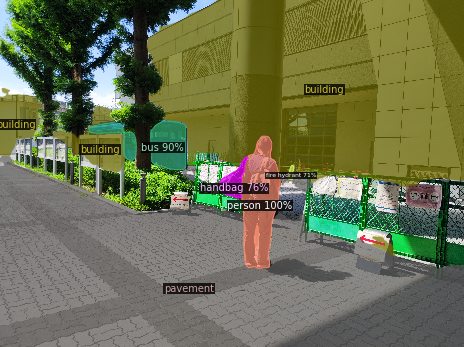

	Categories               	Attributes               
crosswalk           : 11%	man made            :109%
zen_garden          : 10%	natural light       : 82%
loading_dock        :  6%	no horizon          : 62%
playground          :  3%	open area           : 37%
medina              :  3%	sunny               :-22%
zero-shot-image-captioning/img_test/eating_2.jpg


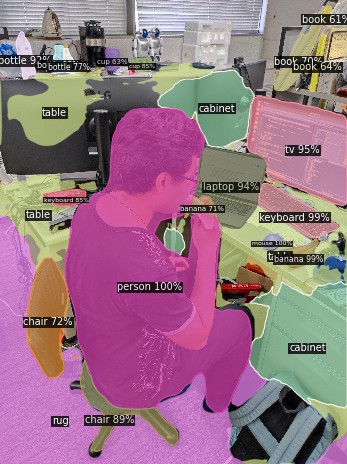

	Categories               	Attributes               
server_room         : 16%	no horizon          : 91%
physics_laboratory  : 11%	man made            : 60%
music_studio        :  8%	enclosed area       : 26%
office_cubicles     :  7%	working             :  9%
repair_shop         :  4%	cloth               :-28%
zero-shot-image-captioning/img_test/bus_1.jpg


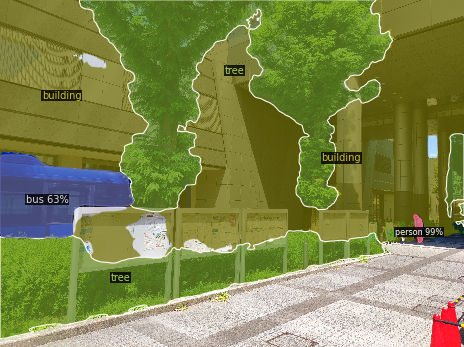

	Categories               	Attributes               
zen_garden          : 15%	man made            :106%
library/outdoor     :  5%	natural light       : 72%
courtyard           :  5%	no horizon          : 59%
campus              :  4%	open area           : 26%
roof_garden         :  3%	vegetation          :-15%
zero-shot-image-captioning/img_test/cycling_2.jpg


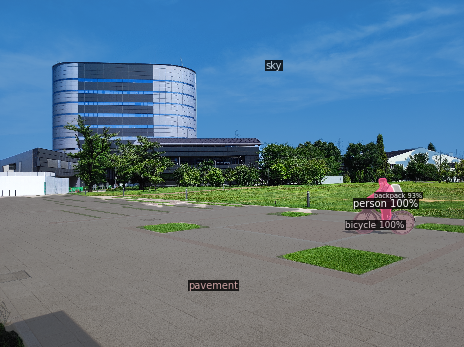

	Categories               	Attributes               
volleyball_court/outdoor: 13%	natural light       :124%
beach_house         : 12%	open area           :123%
campus              : 11%	man made            :102%
hospital            :  4%	sunny               : 56%
zen_garden          :  4%	vegetation          :-13%
zero-shot-image-captioning/img_test/cycling_1.jpg


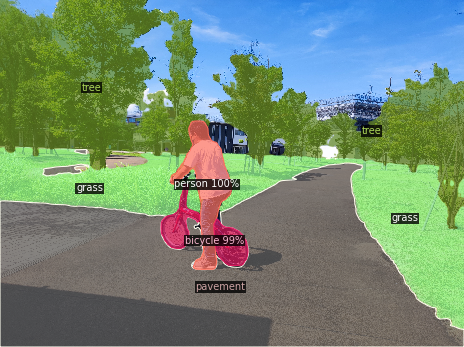

	Categories               	Attributes               
park                : 11%	natural light       :149%
orchard             :  7%	open area           :148%
playground          :  7%	foliage             : 82%
field_road          :  6%	vegetation          : 77%
driveway            :  4%	trees               : 65%
zero-shot-image-captioning/img_test/working_2.jpg


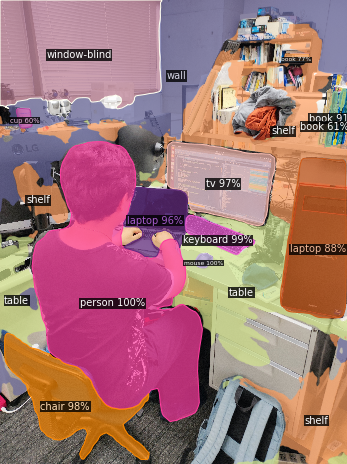

	Categories               	Attributes               
server_room         : 11%	no horizon          : 90%
music_studio        : 10%	man made            : 68%
dorm_room           :  7%	enclosed area       : 52%
physics_laboratory  :  6%	working             : 11%
office_cubicles     :  5%	cluttered space     :-36%
zero-shot-image-captioning/img_test/washing_2.jpg


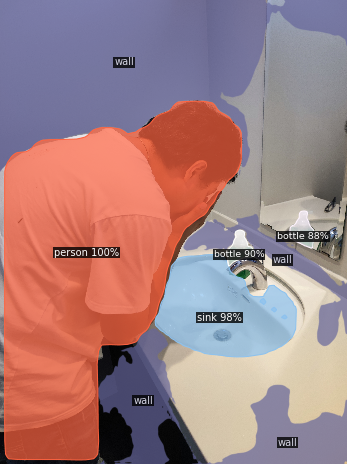

	Categories               	Attributes               
shower              :  9%	no horizon          : 69%
veterinarians_office:  8%	enclosed area       : 68%
bathroom            :  8%	cloth               : 32%
beauty_salon        :  7%	man made            : 17%
chemistry_lab       :  5%	working             : -1%
zero-shot-image-captioning/img_test/washing_1.jpg


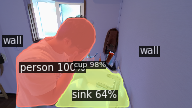

	Categories               	Attributes               
beauty_salon        : 12%	enclosed area       :110%
shower              :  5%	no horizon          : 98%
hospital_room       :  5%	man made            : 33%
utility_room        :  4%	cloth               : -5%
veterinarians_office:  4%	working             :-22%
zero-shot-image-captioning/img_test/eating_1.jpg


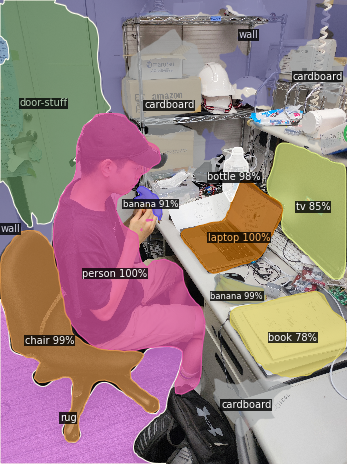

	Categories               	Attributes               
physics_laboratory  : 23%	no horizon          : 90%
repair_shop         :  9%	man made            : 58%
server_room         :  6%	enclosed area       : 46%
music_studio        :  5%	working             : 34%
biology_laboratory  :  4%	cloth               :-23%
zero-shot-image-captioning/img_test/working_1.jpg


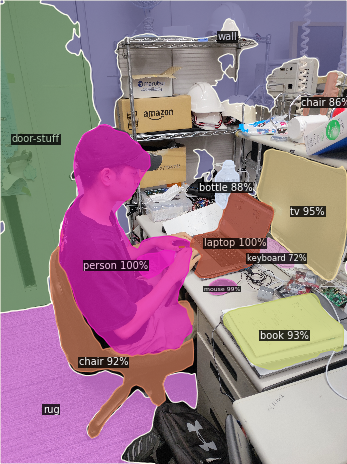

	Categories               	Attributes               
beauty_salon        : 12%	no horizon          : 91%
physics_laboratory  :  8%	man made            : 63%
jewelry_shop        :  7%	enclosed area       : 44%
operating_room      :  5%	working             : 17%
clean_room          :  5%	cloth               :-32%


In [27]:
dirList = os.scandir("zero-shot-image-captioning/img_test")
for filename in dirList:
  if not filename.path.endswith('jpg'):
    continue
  im = cv2.imread(filename.path)
  print(filename.path)
  catResult, attrResult, panoptic_seg, final_segments_info = getImageSymbolics(filename.path)
  
  v = Visualizer(im[:, :, ::-1],
                metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), 
                scale=0.1, 
                )
  # v.draw_instance_predictions(instances.to("cpu"))
  v = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), final_segments_info)
  cv2_imshow(v.get_image()[:, :, ::-1])
  print("\t{:25s}\t{:25s}".format("Categories","Attributes"))
  for v1, v2 in zip(catResult[:5], attrResult[:5]):
    print("{:20s}:{:3.0f}%\t{:20s}:{:3.0f}%".format(v1[0],v1[1]*100, v2[0],v2[1]*100))
  